# Plot

In [101]:
import warnings
warnings.filterwarnings("ignore", message="numpy.dtype size changed")
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import sys
from scipy.optimize import minimize, brentq
from cms_top_20_001_Limits import read_CMSdata, getSMLO, getKfactor

pd.option_context('display.max_columns', -1)

pd.options.mode.chained_assignment = None #Disable copy warnings
# plt.style.use('fivethirtyeight') #Set style
# mpl.rcParams.update({'figure.figsize' : (15,10)})  #Set general plotting options
plt.rcParams.update({
    "text.usetex": True,
    "font.family": "sans-serif",
    "font.sans-serif": ["Helvetica"]})

plt.rcParams.update({"savefig.dpi" : 300}) #Figure resolution


#Define plotting style:
sns.set() #Set style
sns.set_style('ticks',{'font.family':'Times New Roman', 'font.serif':'Times New Roman'})
sns.set_context('paper', font_scale=1.8)
cm = plt.colormaps['RdYlBu']

colors = sns.color_palette('Paired')

### Load Recast Data

In [102]:
recastDataAll = pd.read_pickle('/home/vinicius/EFT_ToyModel/Recast_CMS/pp2ttbar_cms_top_20_001.pcl')
recastDataEFTAll = pd.read_pickle('/home/vinicius/EFT_ToyModel/Recast_CMS/pp2ttbar_eft_cms_top_20_001.pcl')

### Get CMS data

In [103]:
cms_bins = np.array([250.,400.,480.,560.,640.,720.,800.,900.,1000.,
                1150.,1300.,1500.,1700.,2000.,2300.,3500.])
bin_widths  = cms_bins[1:]-cms_bins[:-1] 

# ### Load CMS data
xsecsObs,smNLO,covMatrix,sm_err = read_CMSdata(dataDir='/home/vinicius/EFT_ToyModel/Recast_CMS/data')
smNLO = smNLO/bin_widths
sm_err = sm_err/bin_widths
covTotal = covMatrix + np.diag( (sm_err)**2) 
bgError = np.sqrt(covTotal.diagonal())
#bgError = np.sqrt(covMatrix.diagonal())       

### Get SM prediction and k-factor

In [104]:
# ### Load SM prediction (LO)
smLO = getSMLO('/home/vinicius/EFT_ToyModel/Recast_CMS/sm/sm_tt_lo_cms_top_20_001.pcl')
# ### Load k-factors
kfac = 1.0#getKfactor(smNLO,smLO)
smNLO = smNLO
print(smNLO)
print(xsecsObs)

[3.27717183e-01 8.81521972e-01 5.44329014e-01 3.18260563e-01
 1.82089014e-01 1.09291268e-01 6.47404038e-02 3.65881502e-02
 1.91298404e-02 9.06418779e-03 4.25560563e-03 1.77232207e-03
 6.79761784e-04 2.36470423e-04 3.74685070e-05]
[3.442e-01 8.717e-01 5.428e-01 3.153e-01 1.809e-01 1.096e-01 6.251e-02
 3.697e-02 1.784e-02 9.005e-03 3.815e-03 1.769e-03 6.941e-04 1.905e-04
 3.147e-05]


## Light Point 1

### Select parameters

In [105]:
mPsiT = 700.0
mSDM = 690.0
yDM = 1.0

recastData = recastDataAll[(recastDataAll['mPsiT'] == mPsiT) & (recastDataAll['mSDM'] == mSDM) & (recastDataAll['yDM'] == yDM)]
recastDataEFT = recastDataEFTAll[(recastDataEFTAll['mPsiT'] == mPsiT) & (recastDataEFTAll['mSDM'] == mSDM) & (recastDataEFTAll['yDM'] == yDM)]
mPsiT,mSDM,yDM = recastData[['mPsiT','mSDM','yDM']].iloc[0]
print(mPsiT,mSDM,yDM)
print(len(recastData),len(recastDataEFT))

700.0 690.0 1.0
1 1


### Get signal

In [106]:
binCols = [c for c in recastData.columns 
               if 'bin_' in c.lower() and not 'error' in c.lower()]
bins_left = np.array([eval(c.split('_')[1]) for c in binCols])
bins_right = np.array([eval(c.split('_')[2]) for c in binCols])     
bin_centers = (bins_left+bins_right)/2.0
bin_widths = bins_right-bins_left
cms_bins = np.append(bins_left,bins_right[-1])

signal = list(zip(bins_left,recastData.iloc[0][binCols].values))
signal = np.array(sorted(signal))[:,1]

signalEFT = list(zip(bins_left,recastDataEFT.iloc[0][binCols].values))
signalEFT = np.array(sorted(signalEFT))[:,1]


### Apply k-factors and rescale by bins

In [107]:
signalNLO = signal*kfac/bin_widths
signalEFTNLO = signalEFT*kfac/bin_widths

### Plot distribution and data

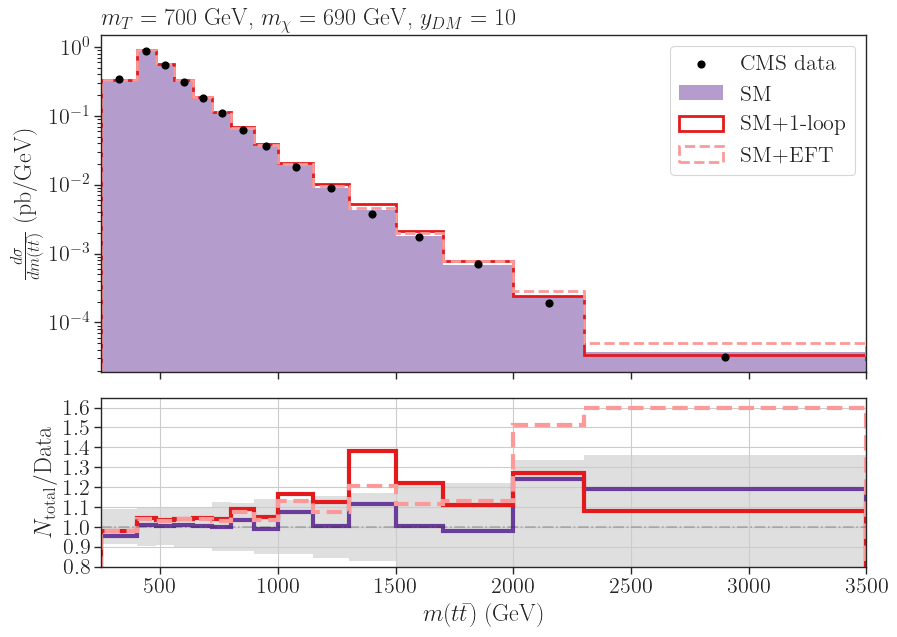

In [108]:
yDM = 10.0/recastData.iloc[0]['yDM']

_, axarr = plt.subplots(2,sharex=True, gridspec_kw = {'height_ratios':[2, 1]},figsize=(9,7))
plt.subplots_adjust(left=0.12, bottom=0.12, right=0.97, top=None, wspace=None, hspace=0.1)

axarr[0].scatter(bin_centers,xsecsObs,label='CMS data',linewidth=2,s=15,
c='black',zorder=10)
axarr[0].hist(bin_centers,weights=smNLO,label=r'SM',histtype='step',linewidth=0,bins=cms_bins,color=colors[9],fill=True,alpha=0.5)
axarr[0].hist(bin_centers,weights=smNLO+signalNLO*yDM**2,label=r'SM+1-loop',histtype='step',linewidth=2,bins=cms_bins,color=colors[5])
axarr[0].hist(bin_centers,weights=smNLO+signalEFTNLO*yDM**2,label=r'SM+EFT',histtype='step',linewidth=2,bins=cms_bins,linestyle='dashed',color=colors[4])
axarr[0].set_yscale('log')
# axarr[0].set_ylim(1e-6,2e-2)
axarr[0].legend()
axarr[0].set_xlim(250.,3500.)
# axarr[0].grid()

axarr[1].hist(bin_centers,weights=np.divide(smNLO,xsecsObs),histtype='step',linewidth=3,bins=cms_bins,color=colors[9])
axarr[1].hist(bin_centers,weights=np.divide(smNLO+signalNLO*yDM**2,xsecsObs),histtype='step',linewidth=3,bins=cms_bins,color=colors[5])
axarr[1].hist(bin_centers,weights=np.divide(smNLO+signalEFTNLO*yDM**2,xsecsObs),histtype='step',linewidth=3,bins=cms_bins,color=colors[4],linestyle='dashed')

axarr[1].bar(x=bins_left, height=np.divide(2*bgError,xsecsObs), bottom=np.divide(xsecsObs-bgError,xsecsObs), width=bin_widths, align='edge', linewidth=0, color='gray', alpha=0.25, zorder=-1, label='uncertainty band')

axarr[1].axhline(y=1, ls = '-.', color = 'k', alpha = 0.25)
axarr[1].set_yticks(np.arange(0.8,1.7,0.1))
axarr[1].set_ylim(0.8,1.65)
axarr[1].grid()

axarr[1].set_xlabel(r'$m(t\bar{t})$ (GeV)')
axarr[0].set_ylabel(r'$\frac{d \sigma}{d m(t\bar{t})}$ (pb/GeV)')
axarr[1].set_ylabel(r'$N_{\rm total}/{\rm Data}$')

axarr[0].set_title(r'$m_T = %1.0f$ GeV, $m_{\chi} = %1.0f$ GeV, $y_{DM} = %1.0f$' %(mPsiT,mSDM,yDM),loc='left')
plt.savefig('CMS_mtt_mPsiT%i_mSDM%i_yDM_%i.png' %(int(mPsiT),int(mSDM),int(yDM)))
plt.show()

## Heavy Point 1

### Select parameters

In [109]:
mPsiT = 1000.0
mSDM = 900.0
yDM = 1.0

recastData = recastDataAll[(recastDataAll['mPsiT'] == mPsiT) & (recastDataAll['mSDM'] == mSDM) & (recastDataAll['yDM'] == yDM)]
recastDataEFT = recastDataEFTAll[(recastDataEFTAll['mPsiT'] == mPsiT) & (recastDataEFTAll['mSDM'] == mSDM) & (recastDataEFTAll['yDM'] == yDM)]
print(len(recastData),len(recastDataEFT))

1 1


### Get signal

In [110]:
binCols = [c for c in recastData.columns 
               if 'bin_' in c.lower() and not 'error' in c.lower()]
bins_left = np.array([eval(c.split('_')[1]) for c in binCols])
bins_right = np.array([eval(c.split('_')[2]) for c in binCols])     
bin_centers = (bins_left+bins_right)/2.0
bin_widths = bins_right-bins_left
cms_bins = np.append(bins_left,bins_right[-1])

signal = list(zip(bins_left,recastData.iloc[0][binCols].values))
signal = np.array(sorted(signal))[:,1]

signalEFT = list(zip(bins_left,recastDataEFT.iloc[0][binCols].values))
signalEFT = np.array(sorted(signalEFT))[:,1]


### Apply k-factors and rescale by bins

In [111]:
signalNLO = signal*kfac/bin_widths
signalEFTNLO = signalEFT*kfac/bin_widths

### Plot distribution and data

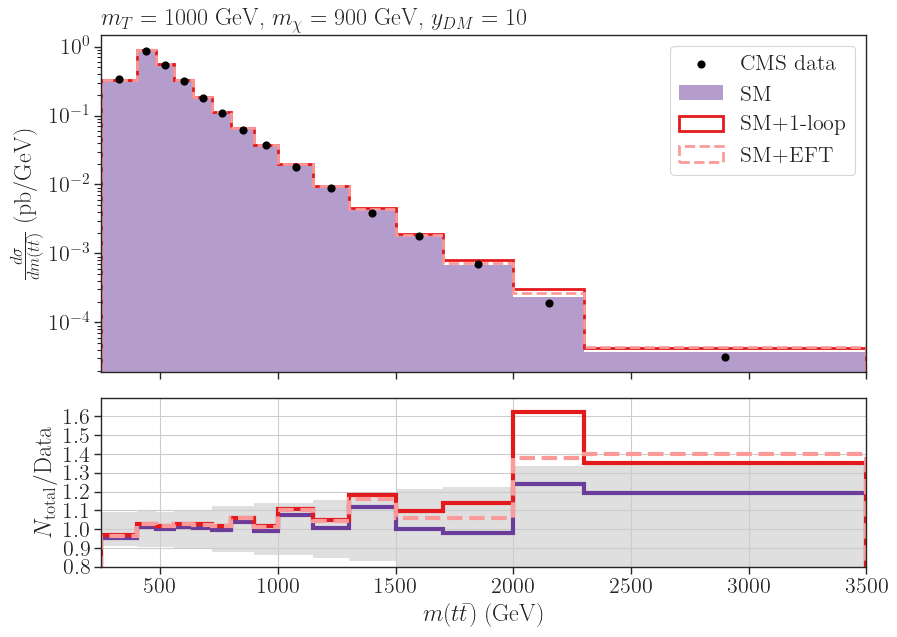

In [112]:
yDM = 10.0/recastData.iloc[0]['yDM']

_, axarr = plt.subplots(2,sharex=True, gridspec_kw = {'height_ratios':[2, 1]},figsize=(9,7))
plt.subplots_adjust(left=0.12, bottom=0.12, right=0.97, top=None, wspace=None, hspace=0.1)

axarr[0].scatter(bin_centers,xsecsObs,label='CMS data',linewidth=2,s=15,
c='black',zorder=10)
axarr[0].hist(bin_centers,weights=smNLO,label=r'SM',histtype='step',linewidth=0,bins=cms_bins,color=colors[9],fill=True,alpha=0.5)
axarr[0].hist(bin_centers,weights=smNLO+signalNLO*yDM**2,label=r'SM+1-loop',histtype='step',linewidth=2,bins=cms_bins,color=colors[5])
axarr[0].hist(bin_centers,weights=smNLO+signalEFTNLO*yDM**2,label=r'SM+EFT',histtype='step',linewidth=2,bins=cms_bins,linestyle='dashed',color=colors[4])
axarr[0].set_yscale('log')
# axarr[0].set_ylim(1e-6,2e-2)
axarr[0].legend()
axarr[0].set_xlim(250.,3500.)
# axarr[0].grid()

axarr[1].hist(bin_centers,weights=np.divide(smNLO,xsecsObs),histtype='step',linewidth=3,bins=cms_bins,color=colors[9])
axarr[1].hist(bin_centers,weights=np.divide(smNLO+signalNLO*yDM**2,xsecsObs),histtype='step',linewidth=3,bins=cms_bins,color=colors[5])
axarr[1].hist(bin_centers,weights=np.divide(smNLO+signalEFTNLO*yDM**2,xsecsObs),histtype='step',linewidth=3,bins=cms_bins,color=colors[4],linestyle='dashed')

# axarr[1].bar(x=bins_left, height=np.divide(2*bgError,xsecsObs), bottom=np.divide(smNLO-bgError,xsecsObs), width=bin_widths, align='edge', linewidth=0, color=colors[0], alpha=0.25, zorder=-1, label='uncertainty band')
axarr[1].bar(x=bins_left, height=np.divide(2*bgError,xsecsObs), bottom=np.divide(xsecsObs-bgError,xsecsObs), width=bin_widths, align='edge', linewidth=0, color='gray', alpha=0.25, zorder=-1, label='uncertainty band')


axarr[1].set_ylim(0.8,1.7)
axarr[1].set_yticks(np.arange(0.8,1.7,0.1))
axarr[1].grid()

axarr[1].set_xlabel(r'$m(t\bar{t})$ (GeV)')
axarr[0].set_ylabel(r'$\frac{d \sigma}{d m(t\bar{t})}$ (pb/GeV)')
axarr[1].set_ylabel(r'$N_{\rm total}/{\rm Data}$')


axarr[0].set_title(r'$m_T = %1.0f$ GeV, $m_{\chi} = %1.0f$ GeV, $y_{DM} = %1.0f$' %(mPsiT,mSDM,yDM),loc='left')
plt.savefig('CMS_mtt_mPsiT%i_mSDM%i_yDM_%i.png' %(int(mPsiT),int(mSDM),int(yDM)))
plt.show()

## Light Point 2

### Select parameters

In [128]:
mPsiT = 300.0
mSDM = 100.0
yDM = 1.0

recastData = recastDataAll[(recastDataAll['mPsiT'] == mPsiT) & (recastDataAll['mSDM'] == mSDM) & (recastDataAll['yDM'] == yDM)]
recastDataEFT = recastDataEFTAll[(recastDataEFTAll['mPsiT'] == mPsiT) & (recastDataEFTAll['mSDM'] == mSDM) & (recastDataEFTAll['yDM'] == yDM)]
print(len(recastData),len(recastDataEFT))

1 1


### Get signal

In [129]:
binCols = [c for c in recastData.columns 
               if 'bin_' in c.lower() and not 'error' in c.lower()]
binColsError = [c for c in recastData.columns 
               if 'bin_' in c.lower() and 'error' in c.lower()]
bins_left = np.array([eval(c.split('_')[1]) for c in binCols])
bins_right = np.array([eval(c.split('_')[2]) for c in binCols])     
bin_centers = (bins_left+bins_right)/2.0
bin_widths = bins_right-bins_left
cms_bins = np.append(bins_left,bins_right[-1])

signal = list(zip(bins_left,recastData.iloc[0][binCols].values))
signal = np.array(sorted(signal))[:,1]

signalError = list(zip(bins_left,recastData.iloc[0][binColsError].values))
signalError = np.array(sorted(signalError))[:,1]

signalEFT = list(zip(bins_left,recastDataEFT.iloc[0][binCols].values))
signalEFT = np.array(sorted(signalEFT))[:,1]

signalEFTError = list(zip(bins_left,recastDataEFT.iloc[0][binColsError].values))
signalEFTError = np.array(sorted(signalEFTError))[:,1]

### Apply k-factors and rescale by bins

In [130]:
signalNLO = signal*kfac/bin_widths
signalEFTNLO = signalEFT*kfac/bin_widths
signalNLOError = signalError*kfac/bin_widths
signalEFTNLOError = signalEFTError*kfac/bin_widths

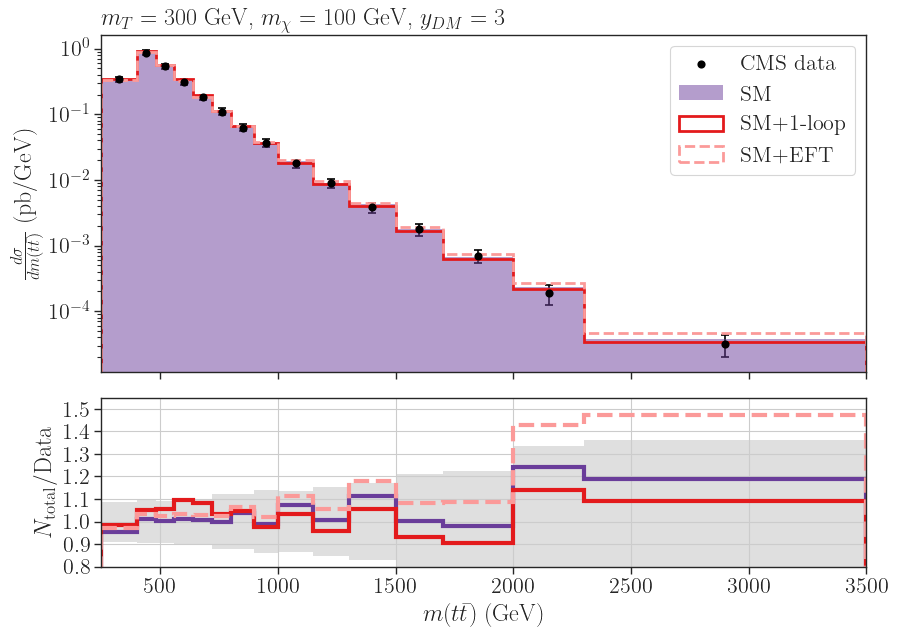

In [131]:
yDM = 3.0/recastData.iloc[0]['yDM']
#Error of sm + signal

sm_sig_Error = np.sqrt(sm_err**2 + (yDM**2 * signalNLOError)**2)

sm_sigEFT_Error = np.sqrt(sm_err**2 + (yDM**2 * signalEFTNLOError)**2)



#ratios

r_sm = np.divide(smNLO,xsecsObs)

r_sig = np.divide(smNLO+signalNLO*yDM**2,xsecsObs)

r_sigEFT = np.divide(smNLO+signalEFTNLO*yDM**2,xsecsObs)



#Propagating the error to the ratio

ratio_smError = r_sm * np.sqrt((sm_err/smNLO)**2 + (bgError/xsecsObs)**2)

ratio_sigError = r_sig * np.sqrt((sm_sig_Error/(smNLO+signalNLO*yDM**2))**2 + (bgError/xsecsObs)**2)

ratio_sigEFTError = r_sigEFT * np.sqrt((sm_sig_Error/(smNLO+signalEFTNLO*yDM**2))**2 + (bgError/xsecsObs)**2)

shift_unit = 0.12 * bin_widths 

_, axarr = plt.subplots(2, sharex=True, gridspec_kw={'height_ratios': [2, 1]}, figsize=(9, 7))
plt.subplots_adjust(left=0.12, bottom=0.12, right=0.97, top=None, wspace=None, hspace=0.1)


axarr[0].scatter(bin_centers, xsecsObs, label='CMS data', linewidth=2, s=15, c='black', zorder=10)
axarr[0].errorbar(bin_centers, xsecsObs, yerr=bgError, color='black', fmt='none', capsize=3, capthick=1.2, barsabove=True)

# Histograms (Step plots stay at true center for visual continuity)
sm_hist = axarr[0].hist(bin_centers, weights=smNLO, label=r'SM', histtype='step', linewidth=0, bins=cms_bins, color=colors[9], fill=True, alpha=0.5)
sm_sig_hist = axarr[0].hist(bin_centers, weights=smNLO+signalNLO*yDM**2, label=r'SM+1-loop', histtype='step', linewidth=2, bins=cms_bins, color=colors[5])
sm_sigEFT_hist = axarr[0].hist(bin_centers, weights=smNLO+signalEFTNLO*yDM**2, label=r'SM+EFT', histtype='step', linewidth=2, bins=cms_bins, linestyle='dashed', color=colors[4])



#axarr[0].errorbar(bin_centers - 1.2*shift_unit, sm_hist[0], yerr=sm_err, 
 #                 color=colors[0], fmt='none', capsize=3, capthick=1.2, barsabove=True)


#axarr[0].errorbar(bin_centers + 1.2*shift_unit, sm_sig_hist[0], yerr=sm_sig_Error, 
  #                color=colors[5], fmt='none', capsize=3, capthick=1.2, barsabove=True)


#axarr[0].errorbar(bin_centers + 2.6*shift_unit, sm_sigEFT_hist[0], yerr=sm_sigEFT_Error, 
 #                 color=colors[4], fmt='none', capsize=3, capthick=1.2, barsabove=True)

axarr[0].set_yscale('log')
axarr[0].legend()
axarr[0].set_xlim(250., 3500.)

sm_r = axarr[1].hist(bin_centers, weights=np.divide(smNLO, xsecsObs), histtype='step', linewidth=3, bins=cms_bins, color=colors[9])
sig_r = axarr[1].hist(bin_centers, weights=np.divide(smNLO+signalNLO*yDM**2, xsecsObs), histtype='step', linewidth=3, bins=cms_bins, color=colors[5])
sigEFT_r = axarr[1].hist(bin_centers, weights=np.divide(smNLO+signalEFTNLO*yDM**2, xsecsObs), histtype='step', linewidth=3, bins=cms_bins, color=colors[4], linestyle='dashed')


axarr[1].bar(x=bins_left, height=np.divide(2*bgError, xsecsObs), bottom=np.divide(xsecsObs-bgError, xsecsObs), 
             width=bin_widths, align='edge', linewidth=0, color='gray', alpha=0.25, zorder=-1, label='uncertainty band')


#axarr[1].errorbar(bin_centers - 1.2*shift_unit, sm_r[0], yerr=ratio_smError, 
                  #color=colors[0], fmt='none', capsize=3, capthick=1.2, barsabove=True)


#axarr[1].errorbar(bin_centers + 1.2*shift_unit, sig_r[0], yerr=ratio_sigError,
                  #color=colors[5], fmt='none', capsize=3, capthick=1.2, barsabove=True)

#axarr[1].errorbar(bin_centers + 2.6*shift_unit, sigEFT_r[0], yerr=ratio_sigEFTError, 
                  #color=colors[4], fmt='none', capsize=3, capthick=1.2, barsabove=True)

axarr[1].set_yticks(np.arange(0.8, 1.6, 0.1))
axarr[1].set_ylim(0.8, 1.55)
axarr[1].grid()

axarr[1].set_xlabel(r'$m(t\bar{t})$ (GeV)')
axarr[0].set_ylabel(r'$\frac{d \sigma}{d m(t\bar{t})}$ (pb/GeV)')
axarr[1].set_ylabel(r'$N_{\rm total}/{\rm Data}$')

axarr[0].set_title(r'$m_T = %1.0f$ GeV, $m_{\chi} = %1.0f$ GeV, $y_{DM} = %1.0f$' %(mPsiT, mSDM, yDM), loc='left')
plt.savefig('CMS_mtt_mPsiT%i_mSDM%i_yDM_%i.png' %(int(mPsiT), int(mSDM), int(yDM)))
plt.show()

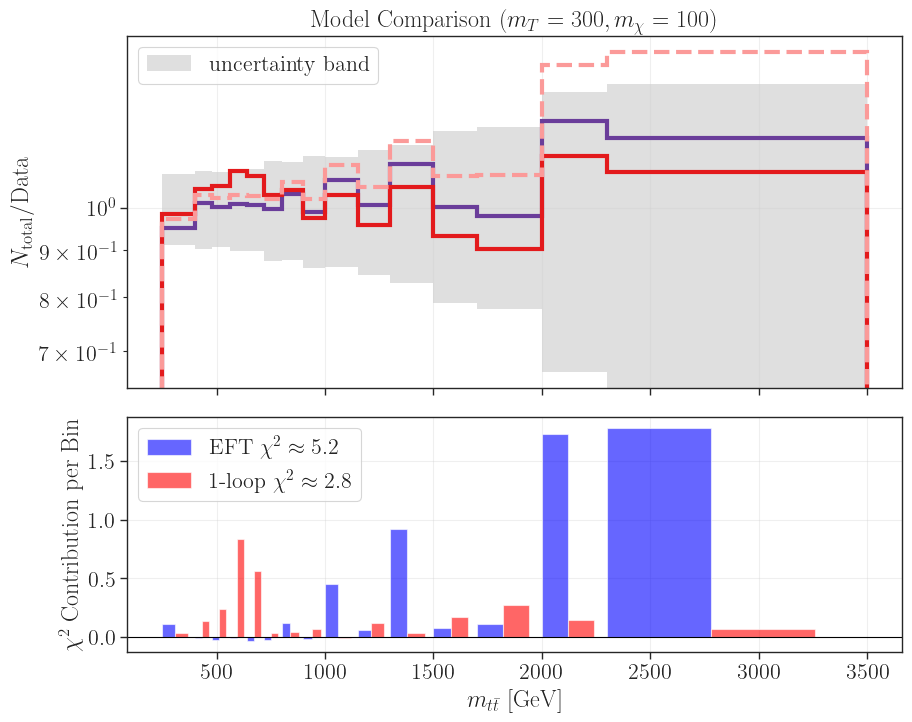

In [134]:
yDM = 3.0/recastData.iloc[0]['yDM']
theory_EFT = smNLO + (yDM**2) * signalEFTNLO

theory_1loop = smNLO + (yDM**2) * signalNLO  # Assuming this is your second model



# --- 2. Calculate Chi2 Contributions for EFT ---

diff_EFT = theory_EFT - xsecsObs

# Note: If Covariance depends on signal, you might need two Vinv matrices. 

# Here we assume one Vinv (usually Data + BG systematics) for comparison.

Vinv = np.linalg.inv(covTotal) 



weighted_diff_EFT = Vinv.dot(diff_EFT)

bin_contributions_EFT = diff_EFT * weighted_diff_EFT

chi2_total_EFT = np.sum(bin_contributions_EFT)



# --- 3. Calculate Chi2 Contributions for 1-loop ---

diff_1loop = theory_1loop - xsecsObs

weighted_diff_1loop = Vinv.dot(diff_1loop)

bin_contributions_1loop = diff_1loop * weighted_diff_1loop

chi2_total_1loop = np.sum(bin_contributions_1loop)



# --- 4. Plotting ---

fig, ax = plt.subplots(2, 1, figsize=(10, 8), sharex=True, gridspec_kw={'height_ratios': [3, 2]})

plt.subplots_adjust(hspace=0.1)



# --- TOP PANEL: Data vs Theories ---

bin_centers = cms_bins[:-1] + bin_widths/2



sm_r = ax[0].hist(bin_centers, weights=np.divide(smNLO, xsecsObs), histtype='step', linewidth=3, bins=cms_bins, color=colors[9])

sig_r = ax[0].hist(bin_centers, weights=np.divide(smNLO+signalNLO*yDM**2, xsecsObs), histtype='step', linewidth=3, bins=cms_bins, color=colors[5])

sigEFT_r = ax[0].hist(bin_centers, weights=np.divide(smNLO+signalEFTNLO*yDM**2, xsecsObs), histtype='step', linewidth=3, bins=cms_bins, color=colors[4], linestyle='dashed')

ax[0].bar(x=bins_left, height=np.divide(2*bgError, xsecsObs), bottom=np.divide(xsecsObs-bgError, xsecsObs), 

             width=bin_widths, align='edge', linewidth=0, color='gray', alpha=0.25, zorder=-1, label='uncertainty band')

ax[0].set_yscale('log')

ax[0].set_ylabel(r'$N_{\rm total}/{\rm Data}$')

ax[0].legend()

ax[0].grid(True, alpha=0.3)

ax[0].set_title(rf'Model Comparison ($m_T = {mPsiT:.0f}, m_\chi = {mSDM:.0f}$)')



# --- BOTTOM PANEL: Chi2 Contributions ---

# We split the bin width to show bars side-by-side

# Shift EFT left, 1-loop right

width_ratio = 0.4 # Bars take up 40% of bin width each

x_EFT   = cms_bins[:-1] # Left edge

x_1loop = cms_bins[:-1] + bin_widths * width_ratio # Offset for second bar



ax[1].bar(x_EFT, bin_contributions_EFT, width=bin_widths*width_ratio, align='edge', 

          color='blue', alpha=0.6, label=rf'EFT $\chi^2 \approx {chi2_total_EFT:.1f}$')



ax[1].bar(x_1loop, bin_contributions_1loop, width=bin_widths*width_ratio, align='edge', 

          color='red', alpha=0.6, label=rf'1-loop $\chi^2 \approx {chi2_total_1loop:.1f}$')



ax[1].set_ylabel(r'$\chi^2$ Contribution per Bin')

ax[1].set_xlabel(r'$m_{t\bar{t}}$ [GeV]')

ax[1].axhline(0, color='black', linewidth=0.8)

ax[1].grid(True, alpha=0.3)

ax[1].legend()



# Optional: Add text box for totals if legend is too crowded

# stats_text = f"EFT $\chi^2$: {chi2_total_EFT:.1f}\n1-loop $\chi^2$: {chi2_total_1loop:.1f}"

# ax[1].text(0.95, 0.9, stats_text, transform=ax[1].transAxes, ha='right', va='top', bbox=dict(facecolor='white', alpha=0.8))



plt.show()

Optimal yDM (EFT): 0.000, Chi2: 1.86
Optimal yDM (1-loop): 1.771, Chi2: 1.50


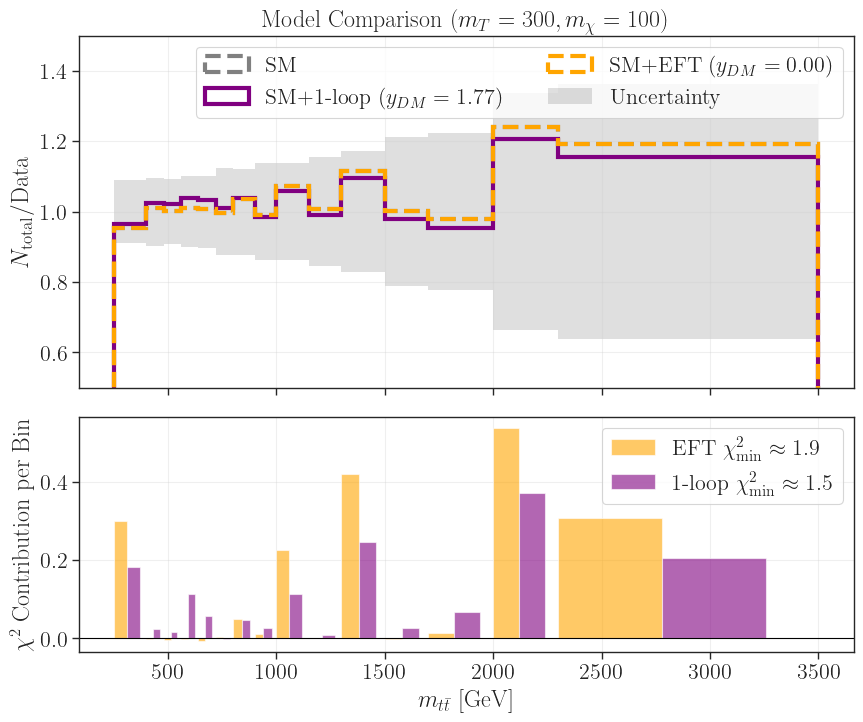

In [133]:


# --- Helper Function: Chi2 Calculation ---
def chi2_func(y, sm, signal, data, inv_cov):
    """
    Calculates total chi2 for a given yDM value (y).
    Theory = SM + y^2 * Signal
    """
    # Assuming y is a 1D array from minimize, take first element
    y_val = y[0] if isinstance(y, (list, np.ndarray)) else y
    
    theory = sm + (y_val**2) * signal
    diff = theory - data
    return diff.dot(inv_cov).dot(diff)

# --- 1. Find yDM that Minimizes Chi2 ---
# We assume 'covTotal' corresponds to the appropriate covariance (e.g., Data + BG systematics)
Vinv = np.linalg.inv(covTotal)

# Minimize for EFT
res_EFT = minimize(chi2_func, x0=[1.0], args=(smNLO, signalEFTNLO, xsecsObs, Vinv))
yDM_min_EFT = res_EFT.x[0]
chi2_min_EFT = res_EFT.fun

# Minimize for 1-loop
res_1loop = minimize(chi2_func, x0=[1.0], args=(smNLO, signalNLO, xsecsObs, Vinv))
yDM_min_1loop = res_1loop.x[0]
chi2_min_1loop = res_1loop.fun

print(f"Optimal yDM (EFT): {yDM_min_EFT:.3f}, Chi2: {chi2_min_EFT:.2f}")
print(f"Optimal yDM (1-loop): {yDM_min_1loop:.3f}, Chi2: {chi2_min_1loop:.2f}")

# --- 2. Calculate Theory & Contributions at Minimum ---
theory_EFT_min = smNLO + (yDM_min_EFT**2) * signalEFTNLO
diff_EFT = theory_EFT_min - xsecsObs
weighted_diff_EFT = Vinv.dot(diff_EFT)
bin_contributions_EFT = diff_EFT * weighted_diff_EFT

theory_1loop_min = smNLO + (yDM_min_1loop**2) * signalNLO
diff_1loop = theory_1loop_min - xsecsObs
weighted_diff_1loop = Vinv.dot(diff_1loop)
bin_contributions_1loop = diff_1loop * weighted_diff_1loop

# --- 3. Plotting ---
fig, ax = plt.subplots(2, 1, figsize=(10, 8), sharex=True, gridspec_kw={'height_ratios': [3, 2]})
plt.subplots_adjust(hspace=0.1)

# --- TOP PANEL: Data vs Theories (Ratio to Data) ---
bin_centers = cms_bins[:-1] + bin_widths/2

# Note: The user requested a Ratio plot in the Top Panel based on their snippet
# "sm_r = ax[0].hist(..., weights=np.divide(smNLO, xsecsObs)...)"
# I will adapt this logic to show the optimized theories.

colors1 = ['black', 'blue', 'red', 'green', 'orange', 'purple', 'brown', 'pink', 'gray', 'olive'] # Fallback colors if 'colors' not defined

# SM Ratio
ax[0].hist(bin_centers, weights=np.divide(smNLO, xsecsObs), histtype='step', linewidth=3, bins=cms_bins, color='gray', label='SM', linestyle='--')

# Optimized 1-loop Ratio
ax[0].hist(bin_centers, weights=np.divide(theory_1loop_min, xsecsObs), histtype='step', linewidth=3, bins=cms_bins, color=colors1[5], label=rf'SM+1-loop ($y_{{DM}}={yDM_min_1loop:.2f}$)')

# Optimized EFT Ratio
ax[0].hist(bin_centers, weights=np.divide(theory_EFT_min, xsecsObs), histtype='step', linewidth=3, bins=cms_bins, color=colors1[4], linestyle='dashed', label=rf'SM+EFT ($y_{{DM}}={yDM_min_EFT:.2f}$)')

# Uncertainty Band
# Assuming 'bgError' is defined in scope (e.g. from covariance diagonal)
# If not, we approximate from Vinv or assume diagonal part of covTotal
bgError = np.sqrt(np.diag(covTotal)) 

ax[0].bar(x=cms_bins[:-1], height=np.divide(2*bgError, xsecsObs), bottom=np.divide(xsecsObs-bgError, xsecsObs), 
             width=bin_widths, align='edge', linewidth=0, color='gray', alpha=0.25, zorder=-1, label='Uncertainty')

ax[0].set_yscale('linear') # Ratio plots are usually linear, user had log but ratio ~1
# ax[0].set_yscale('log') # Uncomment if user strictly wants log for ratio
ax[0].set_ylabel(r'$N_{\rm total}/{\rm Data}$')
ax[0].legend(loc='upper right', ncol=2)
ax[0].grid(True, alpha=0.3)
ax[0].set_title(rf'Model Comparison ($m_T = {mPsiT:.0f}, m_\chi = {mSDM:.0f}$)')
ax[0].set_ylim(0.5, 1.5) # Typical ratio range

# --- BOTTOM PANEL: Chi2 Contributions ---
# We split the bin width to show bars side-by-side
width_ratio = 0.4 # Bars take up 40% of bin width each
x_EFT   = cms_bins[:-1] # Left edge
x_1loop = cms_bins[:-1] + bin_widths * width_ratio # Offset for second bar

ax[1].bar(x_EFT, bin_contributions_EFT, width=bin_widths*width_ratio, align='edge', 
          color=colors1[4], alpha=0.6, label=rf'EFT $\chi^2_{{\rm min}} \approx {chi2_min_EFT:.1f}$')

ax[1].bar(x_1loop, bin_contributions_1loop, width=bin_widths*width_ratio, align='edge', 
          color=colors1[5], alpha=0.6, label=rf'1-loop $\chi^2_{{\rm min}} \approx {chi2_min_1loop:.1f}$')

ax[1].set_ylabel(r'$\chi^2$ Contribution per Bin')
ax[1].set_xlabel(r'$m_{t\bar{t}}$ [GeV]')
ax[1].axhline(0, color='black', linewidth=0.8)
ax[1].grid(True, alpha=0.3)
ax[1].legend()

plt.show()